In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import networkx
import pandas as pd
import matplotlib.pyplot as plt
import networkx.generators.small


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:

path=r'/gdrive/My Drive/amazon-meta.txt'
# open file to read amazon product metadata 
# Dataset: http://snap.stanford.edu/data/amazon-meta.html
fhr = open(path, encoding='utf-8', errors='ignore')

# initialize a nested product dictionary that will hold cleaned up amazon product data
# key = ASIN; value = MetaData associated with ASIN
amazonProductsND = {}
lm = WordNetLemmatizer()
sw = stopwords.words("english")
# read the data from the amazon-meta file;
# populate amazonProductsND nested dicitonary;
(Id, ASIN, Title,Title_wostop, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff) = \
    ("", "", "","", "", "", "", 0, 0, 0.0, 0, 0.0)
for line in fhr:
    line = line.strip()
    # a product block started
    if(line.startswith("Id")):
        Id = line[3:].strip()
    elif(line.startswith("ASIN")):
        ASIN = line[5:].strip()
    elif(line.startswith("title")):
        Title = line[6:].strip()
        Title = ' '.join(Title.split())
        Title_wostop = line[6:].strip()
        Title_wostop = ' '.join(Title_wostop.split())
        Title_wostop = re.compile('[%s]' % re.escape(string.digits+string.punctuation)).sub(' ', Title_wostop)
        #Title_wostop = Title_wostop.split()
        Title_wostop = ' '.join([lm.lemmatize(s) for s in Title_wostop.split() if s not in sw])
    elif(line.startswith("group")):
        Group = line[6:].strip()
    elif(line.startswith("salesrank")):
        SalesRank = line[10:].strip()
    elif(line.startswith("similar")):
        ls = line.split()
        Copurchased = ' '.join([c for c in ls[2:]])
    elif(line.startswith("categories")):
        ls = line.split()
        Categories = ' '.join((fhr.readline()).lower() for i in range(int(ls[1].strip())))
        Categories = re.compile('[%s]' % re.escape(string.digits+string.punctuation)).sub(' ', Categories)
        Categories = ' '.join(set(Categories.split())-set(stopwords.words("english")))
    elif(line.startswith("reviews")):
        ls = line.split()
        TotalReviews = ls[2].strip()
        AvgRating = ls[7].strip()
    # a product block ended
    # write out fields to amazonProductsND Dictionary
    elif (line==""):
        try:
            MetaData = {}
            if (ASIN != ""):
                amazonProductsND[ASIN]=MetaData
            MetaData['Id'] = Id            
            MetaData['Title'] = Title
            MetaData['Title_wostop'] =  Title_wostop
            MetaData['Categories'] = ' '.join(set(Categories.split()))
            MetaData['Group'] = Group
            MetaData['Copurchased'] = Copurchased
            MetaData['SalesRank'] = int(SalesRank)
            MetaData['TotalReviews'] = int(TotalReviews)
            MetaData['AvgRating'] = float(AvgRating)
            MetaData['DegreeCentrality'] = DegreeCentrality
            MetaData['ClusteringCoeff'] = ClusteringCoeff
        except NameError:
            continue
        (Id, ASIN, Title,Title_wostop, Categories, Group, Copurchased, SalesRank, TotalReviews, AvgRating, DegreeCentrality, ClusteringCoeff) = \
            ("", "", "", "","" ,"", "", 0, 0, 0.0, 0, 0.0)
fhr.close()

# create books-specific dictionary exclusively for books
amazonBooksND = {}
for asin,metadata in amazonProductsND.items():
    if (metadata['Group']=='Book'):
        amazonBooksND[asin] = amazonProductsND[asin]

#amazonNd= {}
#for asin,metadata in amazonProductsND.items():
#  amazonNd[asin] = amazonProductsND[asin]
    
# remove any copurchased items from copurchase list 
# if we don't have metadata associated with it 
for asin, metadata in amazonBooksND.items(): 
    amazonBooksND[asin]['Copurchased'] = \
        ' '.join([cp for cp in metadata['Copurchased'].split() \
            if cp in amazonBooksND.keys()])
        
#for asin, metadata in amazonNd.items(): 
#    amazonNd[asin]['Copurchased'] = \
#       ' '.join([cp for cp in metadata['Copurchased'].split() \
#            if cp in amazonNd.keys()])

In [0]:
# create a book copurchase graph for analysis
# where the graph nodes are book ASINs;
# and graph edge exists if two books were copurchased,
# with edge weight being a measure of category similarity between ASINs
copurchaseGraph_common = networkx.Graph()
for asin,metadata in amazonNd.items():
    copurchaseGraph_common.add_node(asin)
    for a in metadata['Copurchased'].split():
        copurchaseGraph_common.add_node(a.strip())
        similarity = 0   

        n1 = set((amazonNd[asin]['Categories']).split()).union(set((amazonNd[asin]['Title_wostop']).split()))
        n2 = set((amazonNd[a]['Categories']).split()).union(set((amazonNd[a]['Title_wostop']).split()))
        #print(n1)
        n1In2 = n1 & n2
        n1Un2 = n1 | n2
        if (len(n1Un2)) > 0:
            similarity = round(len(n1In2)/len(n1Un2),2)
        copurchaseGraph_common.add_edge(asin, a.strip(), weight=similarity)

# get degree centrality and clustering coefficients 
# of each ASIN and add it to amazonBooks metadata
dc = networkx.degree(copurchaseGraph_common)
for asin in networkx.nodes(copurchaseGraph_common):
    metadata = amazonNd[asin]
    metadata['DegreeCentrality'] = int(dc[asin])
    ego = networkx.ego_graph(copurchaseGraph_common, asin, radius=1)
    metadata['ClusteringCoeff'] = networkx.clustering(ego, asin)
    amazonNd[asin] = metadata



In [0]:
# create a book copurchase graph for analysis
# where the graph nodes are book ASINs;
# and graph edge exists if two books were copurchased,
# with edge weight being a measure of category similarity between ASINs
copurchaseGraph = networkx.Graph()
for asin,metadata in amazonBooksND.items():
    copurchaseGraph.add_node(asin)
    for a in metadata['Copurchased'].split():
        copurchaseGraph.add_node(a.strip())
        similarity = 0   

        n1 = set((amazonBooksND[asin]['Categories']).split()).union(set((amazonBooksND[asin]['Title_wostop']).split()))
        n2 = set((amazonBooksND[a]['Categories']).split()).union(set((amazonBooksND[a]['Title_wostop']).split()))
        #print(n1)
        n1In2 = n1 & n2
        n1Un2 = n1 | n2
        if (len(n1Un2)) > 0:
            similarity = round(len(n1In2)/len(n1Un2),2)
        copurchaseGraph.add_edge(asin, a.strip(), weight=similarity)

# get degree centrality and clustering coefficients 
# of each ASIN and add it to amazonBooks metadata
dc = networkx.degree(copurchaseGraph)
for asin in networkx.nodes(copurchaseGraph):
    metadata = amazonBooksND[asin]
    metadata['DegreeCentrality'] = int(dc[asin])
    ego = networkx.ego_graph(copurchaseGraph, asin, radius=1)
    metadata['ClusteringCoeff'] = networkx.clustering(ego, asin)
    amazonBooksND[asin] = metadata



In [0]:
# convert amazonBooks metadata to pandas dataframe and drop redundant columns
amazonBooks = pd.DataFrame(amazonBooksND).T
amazonBooks.drop(columns=['Copurchased', 'Group'], axis=1, inplace=True)

In [0]:
# write amazonBooks dataframe to csv file
amazonBooks.to_csv('/gdrive/My Drive/CIS_509/Individual_Assignments/NetworkAnalysis/amazon-books-title.csv', index=True, header=True)

In [0]:

# write copurchaseGraph data to file
fhw=open("/gdrive/My Drive/CIS_509/Individual_Assignments/NetworkAnalysis/amazon-books-copurchase.edgelist-modified",'wb')
networkx.write_weighted_edgelist(copurchaseGraph, fhw)
fhw.close()



In [0]:

# write copurchaseGraph data to file
fhw=open("/gdrive/My Drive/CIS_509/Individual_Assignments/NetworkAnalysis/amazon-copurchase.edgelist-modified",'wb')
networkx.write_weighted_edgelist(copurchaseGraph, fhw)
fhw.close()



In [0]:
pos=networkx.spring_layout(copurchaseGraph)

In [6]:
plt.figure(figsize=(15,15))
networkx.draw_networkx_nodes(copurchaseGraph,pos,node_size=100)
networkx.draw_networkx_labels(copurchaseGraph,pos,font_size=5)
edgewidth = [d['weight'] for (u,v,d) in copurchaseGraph.edges(data=True)]
networkx.draw_networkx_edges(copurchaseGraph,pos,edge_color=edgewidth,width=edgewidth)
edgelabel = networkx.get_edge_attributes(copurchaseGraph,'weight')
networkx.draw_networkx_edge_labels(copurchaseGraph,pos,edge_labels=edgelabel,font_size=4)
plt.axis('off')
plt.show()

NameError: ignored

<Figure size 1080x1080 with 0 Axes>

In [7]:
purchasedAsin = '0805047905'
purchasedAsinEgoGraph=networkx.Graph()
purchasedAsinEgoGraph = networkx.ego_graph(copurchaseGraph,purchasedAsin,radius=2)
purchasedAsinEgoGraph_neighbors = [ i for i in purchasedAsinEgoGraph.neighbors(purchasedAsin)]
print(purchasedAsinEgoGraph_neighbors)
print(len(purchasedAsinEgoGraph))

['068983568X', '0395900220', '0060235152', '0060262257', '068813954X', '1558587004', '0679875972', '0761309837', '0060207507', '1564021017', '0689835604', '1841480738', '076360013X', '0698114280', '0060255668', '0694003611', '0763619795', '0887081770', '0833547488', '0307120007', '0689847580', '0399226907', '0688159788', '0698116496', '0688104800', '0517800799', '0399207589', '1841484296', '0399220496', '0763619426', '0152021647', '0688085555', '0060207485', '039921822X', '0763621056', '0060207493', '0399216596', '0395287731', '039921478X', '0786803908', '0763616281', '0898459958', '0805059113', '069400491X', '0399237100', '0399215921', '0152021752', '1854303856', '0399218858', '0060207655', '067187893X', '1589250176', '1558580093', '0763621064', '0689853491', '0689829590', '1564024733', '0399234276', '0399208534', '0060207051', '030716327X', '0590677314', '067989344X', '0694016756', '0763604402', '0689809999', '0439146712', '0531071855', '0448421607', '0064435962', '0152026320', '1557

In [0]:
pos=networkx.spring_layout(copurchaseGraph)

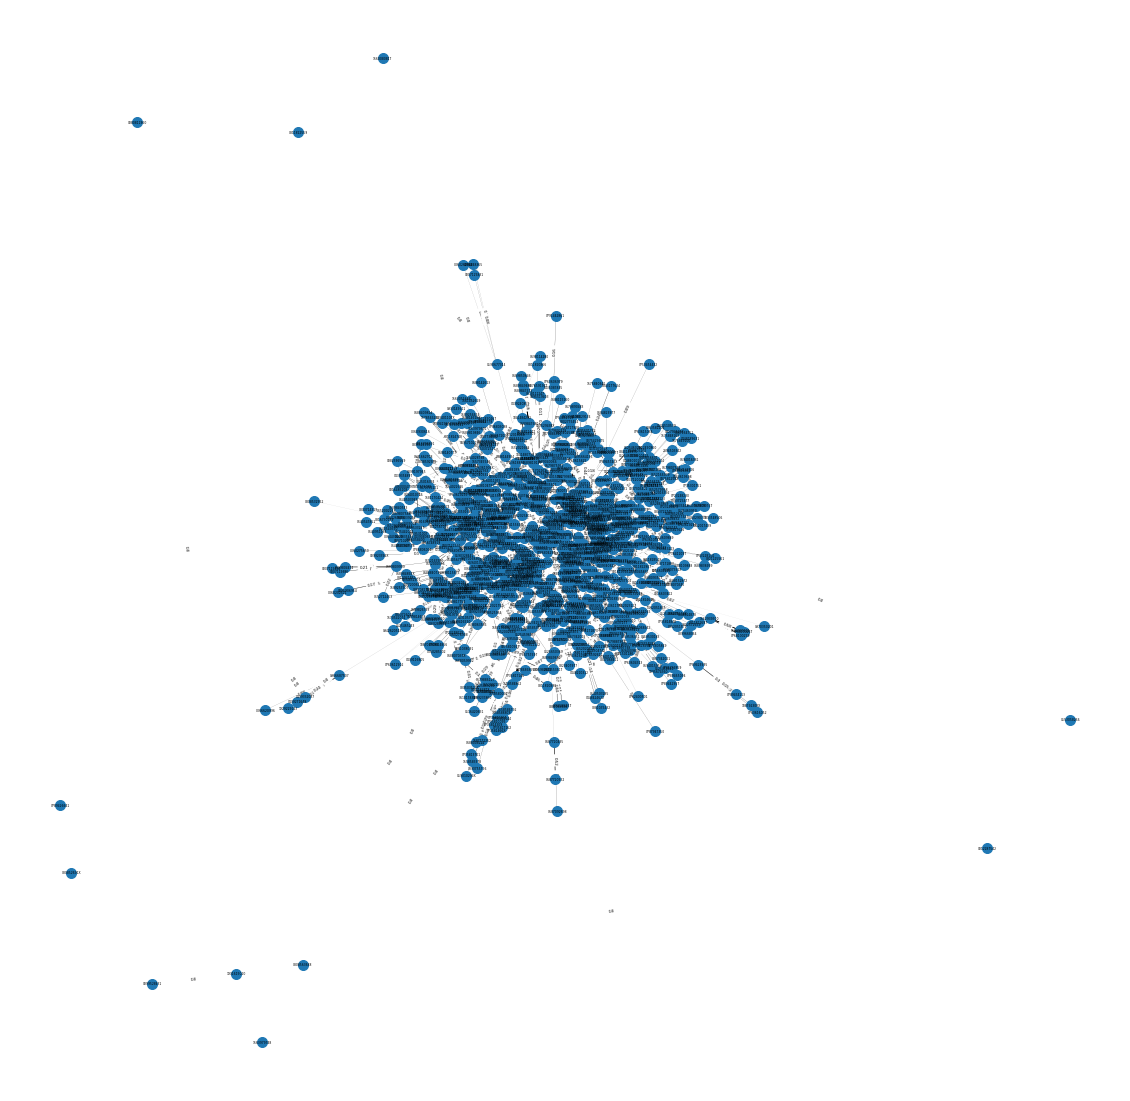

<Figure size 432x288 with 0 Axes>

In [25]:
pos=networkx.spring_layout(purchasedAsinEgoGraph)
plt.figure(figsize=(20,20))
networkx.draw_networkx_nodes(purchasedAsinEgoGraph,pos,node_size=100)
networkx.draw_networkx_labels(purchasedAsinEgoGraph,pos,font_size=3)
edgewidth = [d['weight'] for (u,v,d) in purchasedAsinEgoGraph.edges(data=True)]
node_size = [0.05*v for v in networkx.get_node_attributes(purchasedAsinEgoGraph, 'amazonBooksND')] 
networkx.draw_networkx_edges(purchasedAsinEgoGraph,pos,width=edgewidth)
edgelabel = networkx.get_edge_attributes(purchasedAsinEgoGraph,'weight')
networkx.draw_networkx_edge_labels(purchasedAsinEgoGraph,pos,edge_labels=edgelabel,font_size=4,node_size=node_size)
plt.axis('off')
plt.show()
plt.tight_layout(); 

In [26]:
plt.savefig("/gdrive/My Drive/CIS_509/Individual_Assignments/NetworkAnalysis/graph.png") 

<Figure size 432x288 with 0 Axes>